# APS 1: Software para Análise de Treliças e Validação em Protótipo
---

## Objetivo Geral

O objetivo da atividade é desenvolv|er um software de simulação para análise de treliças planas, projetar uma estrutura com base nos resultados do software

---

### Importando Bibliotecas e Funções que serão usadas no software:

In [37]:
import numpy as np
import math
from funcoesTermosol import importa
from funcoesTermosol import plota
from funcoesTermosol import geraSaida

### Importando os dados
Dados da estrutura:
* nn  = número de nós
* N   = coordenadas dos nós
* nm  = número de membros
* Inc = incidência

Dados do carregamento:
* nc  = número de cargas
* F   = forças
* nr  = número de restrições
* R   = restrições

In [38]:
[nn,N,nm,Inc,nc,F,nr,R] = importa('entradaG6.xlsx')

### Gráfico da estrutura definida pela matriz de nos N  e pela incidencia Inc:

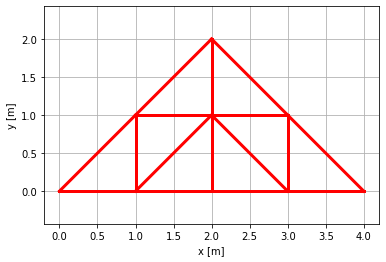

In [39]:
plota(N,Inc)

### Determinação das propriedades de cada elemento: comprimento L, módulo de elasticidade E e área A

In [40]:
L = []
E = []
A = []

relacoes1 = Inc[:,0]
relacoes2 = Inc[:,1]
x = N[0]
y = N[1]

for e in range(nm):
    x1 = x[int(relacoes1[e])-1]
    y1 = y[int(relacoes1[e])-1]
    x2 = x[int(relacoes2[e])-1]
    y2 = y[int(relacoes2[e])-1]
    
    L.append(((x1-x2)**2+(y1-y2)**2)**(1/2))
    E.append(Inc[e][2])
    A.append(Inc[e][3])

### Montagem das matrizes dos elementos:

In [41]:
#calculando os senos e cossenos de cada elemento
cos =[]
sen=[]

for e in range(nm):
    x1 = x[int(relacoes1[e])-1]
    y1 = y[int(relacoes1[e])-1]
    x2 = x[int(relacoes2[e])-1]
    y2 = y[int(relacoes2[e])-1]
    
    sen.append((y2-y1)/L[e])
    cos.append((x2-x1)/L[e])


In [42]:
#construindo as matrizes de rigidez de cada elemento

TK =[]

for e in range(nm):
    c = cos[e]
    s = sen [e]
    T = np.array([[c**2, c*s, -c**2, -c*s],
                [c*s, s**2, -c*s, -s**2],
                 [-c**2, -c*s, c**2, c*s],
                 [-c*s, -s**2, c*s, s**2]])
    TK.append((E[e]*A[e]/L[e]) * (T))

len(TK)

16

### Fazendo a superposição das matrizes – Rigidez global da estrutura

In [43]:
gdl = []
nos = np.delete(Inc, [2,3], 1)
for par in nos:
    lista = []
    lista.append(par[0]*2-2)
    lista.append(par[0]*2-1)
    lista.append(par[1]*2-2)
    lista.append(par[1]*2-1)
    gdl.append(lista)
    

gdlmax = nn*2    
Kglobal = np.zeros((gdlmax, gdlmax))
for ke in range(len(TK)):
    Kglobal[int(gdl[ke][0]):int(gdl[ke][1]+1),int(gdl[ke][0]):int(gdl[ke][1]+1)] += TK[ke][0:2,0:2] # A
    Kglobal[int(gdl[ke][2]):int(gdl[ke][3]+1),int(gdl[ke][0]):int(gdl[ke][1]+1)] += TK[ke][2:4,0:2] # B
    Kglobal[int(gdl[ke][0]):int(gdl[ke][1]+1),int(gdl[ke][2]):int(gdl[ke][3]+1)] += TK[ke][0:2,2:4] # C
    Kglobal[int(gdl[ke][2]):int(gdl[ke][3]+1),int(gdl[ke][2]):int(gdl[ke][3]+1)] += TK[ke][2:4,2:4] # D

### Montagem do vetor de carga global da estrutura:

In [44]:
Fcontorno = np.delete(F, R)
Fcontorno

C:\Users\mucha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  """Entry point for launching an IPython kernel.


array([    0.,     0.,     0.,  2000.,     0.,     0.,     0.,     0.,
           0.,  2000., 10000.])

### Aplicação das condições de contorno:

In [45]:
Kcontorno = np.delete(Kglobal, R, 0)
Kcontorno = np.delete(Kcontorno, R, 1)

C:\Users\mucha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  """Entry point for launching an IPython kernel.
C:\Users\mucha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


### Solução do sistema de equações:

In [46]:
Ut_solve = np.linalg.solve(Kcontorno, Fcontorno)
Ut_solve

array([2.75534644e-07, 1.62744803e-07, 4.99549629e-08, 1.22143612e-06,
       1.75099073e-07, 6.23056619e-07, 7.50825528e-07, 3.50166729e-07,
       2.72889890e-07, 1.33551493e-06, 1.95281042e-06])

### Obtendo todos os os deslocamentos nodais Ut:

In [47]:
Ut = np.zeros((gdlmax,1))
i = 0
for e in range(len(Ut)):
    if e not in R:
        Ut[e] += Ut_solve[i]
        i += 1

Ut

array([[0.00000000e+00],
       [0.00000000e+00],
       [2.75534644e-07],
       [0.00000000e+00],
       [1.62744803e-07],
       [0.00000000e+00],
       [4.99549629e-08],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.22143612e-06],
       [1.75099073e-07],
       [6.23056619e-07],
       [7.50825528e-07],
       [3.50166729e-07],
       [2.72889890e-07],
       [1.33551493e-06],
       [1.95281042e-06]])

### Calculando as reações de apoio Ft:

In [48]:
Ft = np.dot(Kglobal, Ut)

In [49]:
# ajuste nas forças de deslocamento que não deveriam existir

indexes = []
for w in range(len(Ft)):
    if w not in R:
        indexes.append(w)   

Ft = np.delete(Ft, indexes)
Ft

array([-3634.86876688, -2332.96757527, -2662.17630959, -3547.65062167,
       -1586.29952681,  -365.13123312,   129.09403334])

### Calculando as deformações em cada elemento Epsi:

In [50]:
Epsi_list = []
for i in range(nm):
    E_value = E[i]
    c = cos[i]
    s = sen[i]
    L_value = L[i]
    constantesEpsi = np.dot([-c, -s, c, s], 1/L_value)
    deslocamentos = [Ut_todos[int(gdl[i][0])], Ut_todos[int(gdl[i][1])], Ut_todos[int(gdl[i][2])], Ut_todos[int(gdl[i][3])]]
    
    val = np.dot(constantesEpsi, deslocamentos)
    
    Epsi_list.append(val)
    
Epsi = np.dot(Epsi_list, 1)
Epsi

array([[ 2.75534644e-07],
       [-1.12789840e-07],
       [-1.12789840e-07],
       [-4.99549629e-08],
       [ 6.98267595e-07],
       [ 1.75099073e-07],
       [ 5.49173752e-07],
       [ 7.50825528e-07],
       [ 8.88619359e-08],
       [-5.98379497e-07],
       [-2.72889890e-07],
       [ 2.72889890e-07],
       [-3.86384196e-08],
       [ 9.45895079e-07],
       [ 1.20198489e-06],
       [ 3.47286164e-07]])

### Calculando tensões normais internas Ti de cada elemento:

In [51]:
Ti_list=[]
for i in range(len(Epsi)):
    Ti_list.append(Epsi[i]*E[i])

Ti = np.dot(Ti_list, 1)
Ti

array([[  57862.27518256],
       [ -23685.86648495],
       [ -23685.86648495],
       [ -10490.54221267],
       [ 146636.19491206],
       [  36770.80542544],
       [ 115326.48793251],
       [ 157673.36096323],
       [  18661.00654577],
       [-125659.69431433],
       [ -57306.8769191 ],
       [  57306.8769191 ],
       [  -8114.06812308],
       [ 198637.96664411],
       [ 252416.82690302],
       [  72930.09443316]])

### Calculando os esforços normais internos Fi de cada elemento:

In [52]:
Fi_list=[]
for i in range(len(Ti)):
    Fi_list.append(Ti[i]*A[i])

Fi = np.dot(Fi_list, 1)
Fi

array([[ 1301.90119161],
       [ -532.93199591],
       [ -532.93199591],
       [ -236.03719978],
       [ 3299.31438552],
       [  827.34312207],
       [ 2594.84597848],
       [ 3547.65062167],
       [  419.87264728],
       [-2827.34312207],
       [-1289.40473068],
       [ 1289.40473068],
       [ -182.56653277],
       [ 4469.35424949],
       [ 5679.37860532],
       [ 1640.92712475]])

### Gerando o arquivo texto de saída que contém esses resultados:

In [53]:
geraSaida("saidaG6", Ft, Ut_todos, Epsi, Fi, Ti)